## Bibliotēku instalēšana un importēšana

In [20]:
from pathlib import Path
import json
import time
import shutil
from typing import List

import matplotlib.pyplot as plt
from ultralytics import YOLO

from PIL import Image

import torch
import ultralytics

## Ceļu konfigurācija un pamatparametri

In [21]:
DATA_ROOT = Path('.')

train_img_dir = DATA_ROOT / 'train' / 'images'
train_ann_dir = DATA_ROOT / 'train' / 'ann'
val_img_dir = DATA_ROOT / 'val' / 'images'
val_ann_dir = DATA_ROOT / 'val' / 'ann'

train_labels_dir = DATA_ROOT / 'train' / 'labels'
val_labels_dir = DATA_ROOT / 'val' / 'labels'

train_labels_dir.mkdir(parents=True, exist_ok=True)
val_labels_dir.mkdir(parents=True, exist_ok=True)

## Anotāciju konvertēšana: Supervisely JSON → YOLO formāts

In [22]:
def convert_supervisely_json_to_yolo(json_dir: Path, labels_dir: Path, images_dir: Path):
    labels_dir.mkdir(parents=True, exist_ok=True)

    json_files = sorted(json_dir.glob('*.json'))
    print(f'Atrastie JSON: {len(json_files)} direktorijā {json_dir}')

    for json_path in json_files:
        data = json.load(open(json_path, 'r', encoding='utf-8'))

        stem_full = json_path.stem
        img_stem = Path(stem_full).stem

        img_path = None
        for ext in ['.jpg', '.jpeg', '.png']:
            candidate = images_dir / f'{img_stem}{ext}'
            if candidate.exists():
                img_path = candidate
                break

        if img_path is None:
            print(f'BRĪDINĀJUMS: attēls {img_stem} nav atrasts, izlaižu anotācijas')
            continue

        w, h = Image.open(img_path).size

        yolo_lines: List[str] = []
        for obj in data.get('objects', []):
            class_id = 0 

            (x1, y1), (x2, y2) = obj['points']['exterior']
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)

            bw = x2 - x1
            bh = y2 - y1
            cx = x1 + bw / 2
            cy = y1 + bh / 2

            cx_n = cx / w
            cy_n = cy / h
            bw_n = bw / w
            bh_n = bh / h


            if 0 < cx_n < 1 and 0 < cy_n < 1 and 0 < bw_n < 1 and 0 < bh_n < 1:
                yolo_lines.append(
                    f"{class_id} {cx_n:.6f} {cy_n:.6f} {bw_n:.6f} {bh_n:.6f}"
                )

        label_path = labels_dir / f'{img_stem}.txt'
        with open(label_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(yolo_lines))

    print('Konvertēšana pabeigta:', labels_dir)

convert_supervisely_json_to_yolo(train_ann_dir, train_labels_dir, train_img_dir)
convert_supervisely_json_to_yolo(val_ann_dir, val_labels_dir, val_img_dir)


Atrastie JSON: 50 direktorijā train\ann
Konvertēšana pabeigta: train\labels
Atrastie JSON: 18 direktorijā val\ann
Konvertēšana pabeigta: val\labels


##  `data.yaml` 

In [23]:
data_yaml_path = DATA_ROOT / 'data.yaml'
data_yaml_content = f"""
path: .
train: train/images
val: val/images
nc: 1
names:
  0: retail item
""".strip() + "\n"

with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write(data_yaml_content)



## 6. YOLOv8n – apmācība

In [ ]:
EPOCHS = 50 
# EPOCHS = 10
# EPOCHS = 100          
BATCH = 16           
IMG_SIZE = 640

yolo_n = YOLO('yolov8n.pt')


results_n = yolo_n.train(
    data=str(data_yaml_path),
    epochs=EPOCHS,
    batch=BATCH,
    imgsz=IMG_SIZE,
    project='runs_shelves',
    name='yolov8n',
    exist_ok=True,
)

results_n



Ultralytics 8.3.233  Python-3.12.1 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022160999C70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

## 7. YOLOv8m – treniņš

In [25]:
yolo_m = YOLO('yolov8m.pt')
results_m = yolo_m.train(
    data=str(data_yaml_path),
    epochs=EPOCHS,
    batch=BATCH,
    imgsz=IMG_SIZE,
    project='runs_shelves',
    name='yolov8m',
    exist_ok=True,
)
results_m

Ultralytics 8.3.233  Python-3.12.1 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000220BEB7EA80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

## 8. Modeļu kvalitātes salīdzinājums (mAP, recall)

In [26]:
metrics_n = yolo_n.val(data=str(data_yaml_path), imgsz=IMG_SIZE, verbose=False)
metrics_m = yolo_m.val(data=str(data_yaml_path), imgsz=IMG_SIZE, verbose=False)

print('YOLOv8n mAP50-95:', metrics_n.box.map)
print('YOLOv8n mAP50:', metrics_n.box.map50)
print('YOLOv8n Recall:', metrics_n.box.r)
print('-------------------------------')
print('YOLOv8m mAP50-95:', metrics_m.box.map)
print('YOLOv8m mAP50:', metrics_m.box.map50)
print('YOLOv8m Recall:', metrics_m.box.r)

Ultralytics 8.3.233  Python-3.12.1 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 5134.8791.5 MB/s, size: 849.0 KB)
val: Scanning C:\Users\Edward\Documents\RTU\Datizrace2\Project-2\shop_lab\val\labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 18/18  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.4s/it 2.8s5.3s
                   all         18       3086      0.737      0.629      0.712      0.383
Speed: 2.8ms preprocess, 1.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to C:\Users\Edward\Documents\RTU\Datizrace2\Project-2\shop_lab\runs\detect\val3
Ultralytics 8.3.233  Python-3.12.1 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val

## 9. Ātrdarbības mērījumi (ms/attēls, FPS)

In [27]:
from glob import glob

def benchmark_model(model: YOLO, img_paths, warmup: int = 5, runs: int = 20):
    for _ in range(warmup):
        _ = model(img_paths[0])

    t0 = time.time()
    cnt = 0
    for i in range(runs):
        for p in img_paths:
            _ = model(p, verbose=False)
            cnt += 1
    t1 = time.time()
    avg_time = (t1 - t0) / cnt
    ms = avg_time * 1000
    fps = 1.0 / avg_time
    return ms, fps

val_imgs = sorted(glob(str(val_img_dir / '*')))
val_imgs_short = val_imgs[:10]  
print(f'Benchmarking on {len(val_imgs_short)} attēliem...')

ms_n, fps_n = benchmark_model(yolo_n, val_imgs_short)
ms_m, fps_m = benchmark_model(yolo_m, val_imgs_short)

print(f'YOLOv8n: {ms_n:.1f} ms/attēls, {fps_n:.1f} FPS')
print(f'YOLOv8m: {ms_m:.1f} ms/attēls, {fps_m:.1f} FPS')

Benchmarking on 10 attēliem...

image 1/1 c:\Users\Edward\Documents\RTU\Datizrace2\Project-2\shop_lab\val\images\val_107.jpg: 640x480 172 retail items, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\Edward\Documents\RTU\Datizrace2\Project-2\shop_lab\val\images\val_107.jpg: 640x480 172 retail items, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\Edward\Documents\RTU\Datizrace2\Project-2\shop_lab\val\images\val_107.jpg: 640x480 172 retail items, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\Edward\Documents\RTU\Datizrace2\Project-2\shop_lab\val\images\val_107.jpg: 640x480 172 retail items, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\Edward\Documents\RTU\Datizrace2\Project-2\shop_lab\val\im

## 10. Vizuālais salīdzinājums uz plauktu attēliem

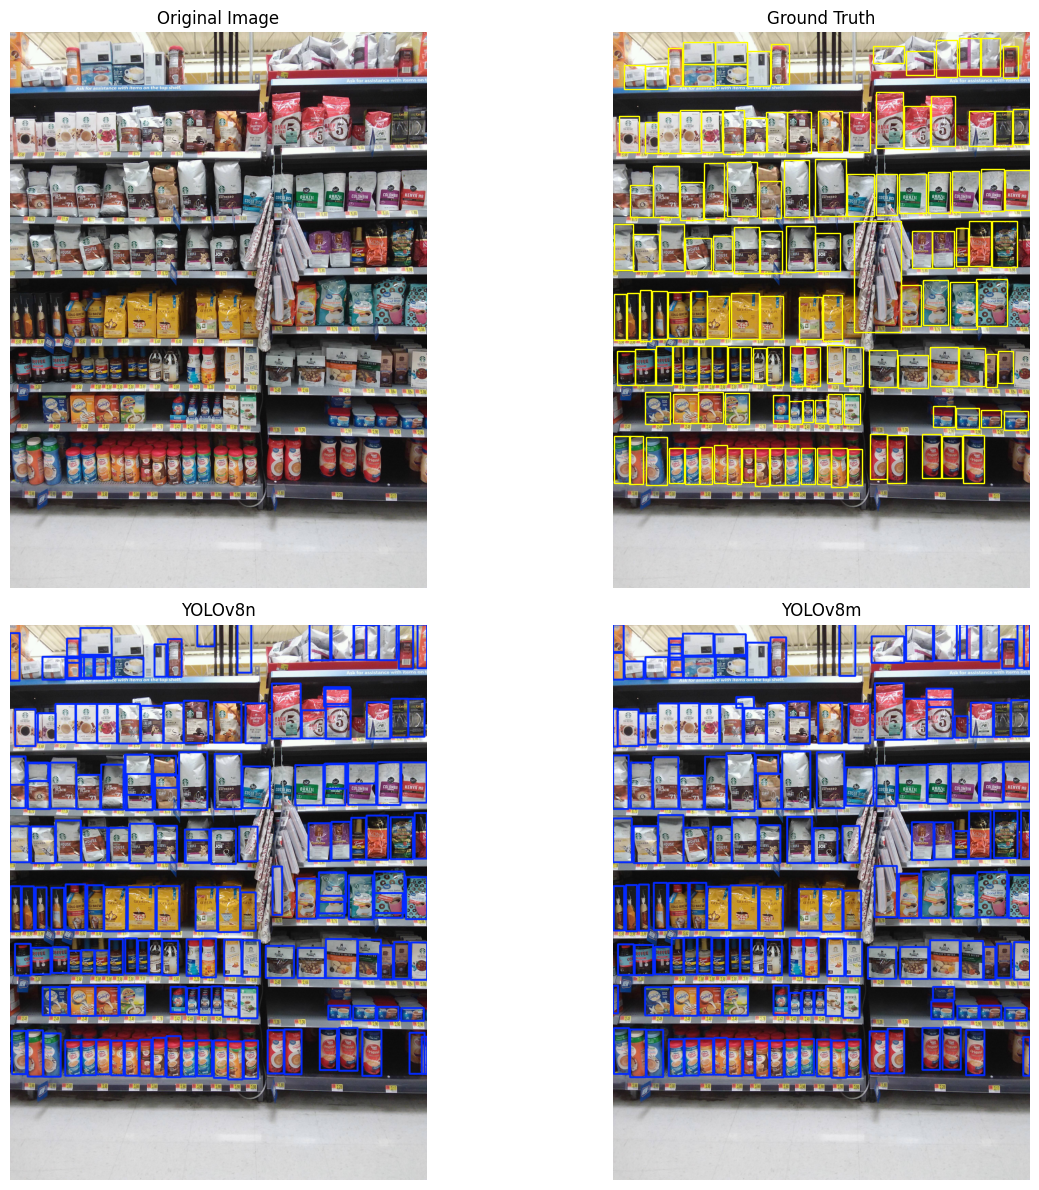

In [ ]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

IMG_PATH = Path("val/images/val_455.jpg")
LABEL_PATH = Path("val/labels/val_455.txt")

def draw_gt(ax, img, lbl_path):
    h, w = img.shape[:2]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Ground Truth")

    if not lbl_path.exists():
        return

    for line in open(lbl_path):
        cls, xc, yc, bw, bh = map(float, line.split())
        x = (xc - bw/2) * w
        y = (yc - bh/2) * h
        rect = Rectangle((x, y), bw*w, bh*h, fill=False, edgecolor='yellow', linewidth=1)
        ax.add_patch(rect)

def compare_one(img_path, model_a, model_b, title_a='YOLOv8n', title_b='YOLOv8m'):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)

    res_a = model_a(img_path, verbose=False)[0]
    res_b = model_b(img_path, verbose=False)[0]

    pred_a = res_a.plot(labels=False)[:, :, ::-1]

    pred_b = res_b.plot(labels=False)[:, :, ::-1]

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    axs[0, 0].imshow(img)
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')

    draw_gt(axs[0, 1], img, LABEL_PATH)

    axs[1, 0].imshow(pred_a)
    axs[1, 0].set_title(title_a)
    axs[1, 0].axis('off')

    axs[1, 1].imshow(pred_b)
    axs[1, 1].set_title(title_b)
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

compare_one(IMG_PATH, yolo_n, yolo_m)
